# Анализ игровых продуктов для интернет-магазина

## Описание проекта

### Цель исследования

На основе анализа представленных данных, необходимо сделать прогноз на следующий год о наиболее популярных игровых продуктах, для планирования рекламной кампании игрового интернет-магазина.

### Источник данных

Данные из открытых источников содержащие сведения о продажах игр, оценках пользователей и экспертов, жанрах и игровых платформах до 2016 года.

**Описание данных:**

`Name` — название игры;

`Platform` — платформа;

`Year_of_Release` — год выпуска;

`Genre` — жанр игры;

`NA_sales` — продажи в Северной Америке (миллионы проданных копий);

`EU_sales` — продажи в Европе (миллионы проданных копий);

`JP_sales` — продажи в Японии (миллионы проданных копий);

`Other_sales` — продажи в других странах (миллионы проданных копий);

`Critic_Score` — оценка критиков (максимум 100);

`User_Score` — оценка пользователей (максимум 10);

`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

### Ход исследования

1. Изучение общей информации о данных.
2. Предобработка данных.
3. Исследовательский анализ данных:
- проанализировать количество выпускаемых игр по годам;
- проанализировать продажи игр по платформам и определить актуальный временной период для дальнейшего анализа;
- определить потенциально прибыльные платформы с прогнозом наибольших продаж;
- проанализировать глобальные продажи игр в разбивке по платформам за актуальный период;
- оценить влияние на продажи оценок пользователей и критиков;
- проанализировать общее распределение игр по жанрам и определить наиболее прибыльные жанры.
4. Изучение региональных особенностей игрового рынка:
- определить топ-5 игровых платформ для каждого региона;
- определить топ-5 игровых жанров для каждого региона;
- оценить влияние рейтинга ESRB на продажи в регионах.
5. Проверка гипотез:
- о равенстве среднего пользовательского рейтинга игр для платформ Xbox One и PC;
- о различиях в среднем пользовательском рейтинге игр жанров Action и Sports.

## Открытие файла с данными и изучение общей информации #

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В названиях столбцов в датафрейме используются заглавные буквы, что не соответствует общепринятой стилистике Pyton. Также в столбцах Platform, Year_of_Release, Genre, Critic_Score, User_Score и Rating есть пропуски. 

## Подготовка данных #

### Замена названий столбцов ##

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.head(1) #проверка

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E


### Преобразование типов данных ##

Преобразуем данные в столбце year_of_release из формата float в int, т.к. год не может быть дробным значением. Так как в этом столбце есть пропуски, которые помешают преобразованию, и их количество относительно невелико (всего 1,6%), то начнем с их удаления.

In [7]:
df = df[~df['year_of_release'].isna()] #удаление строк, содержащих пропуск в столбце с годом выхода игры

In [8]:
df['year_of_release'] = df['year_of_release'].astype(int) #замена типа данных

In [9]:
df['year_of_release'].head()

0    2006
1    1985
2    2008
3    2009
4    1996
Name: year_of_release, dtype: int64

В датафрейме есть несколько столбцов с категориальными данными, а именно platform и rating. Заменим тип данных на category в столбце platform, так датафрейм будет занимать меньше памяти (формат данных в столбце rating пока менять не будем, т.к. в нем есть пропуски с которыми нам ещё предстоит работать).

In [10]:
df['platform'] = df['platform'].astype('category')

Данные в столбце user_scores имеют формат object, т.к. часть данных в нем представлена вещественными числами, а часть строками 'tbd' ('To Be Determined'). Т.е. фактически нам неизвестна пользовательская оценка для этих игр, поэтому изменим в данном столбце формат на float, а значения 'tbd' будут заменены на NaN.

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16446 non-null  category
 2   year_of_release  16446 non-null  int64   
 3   genre            16444 non-null  object  
 4   na_sales         16446 non-null  float64 
 5   eu_sales         16446 non-null  float64 
 6   jp_sales         16446 non-null  float64 
 7   other_sales      16446 non-null  float64 
 8   critic_score     7983 non-null   float64 
 9   user_score       7463 non-null   float64 
 10  rating           9768 non-null   object  
dtypes: category(1), float64(6), int64(1), object(3)
memory usage: 1.4+ MB


### Обработка пропусков ##

In [15]:
df[['user_score', 'critic_score']] = df[['user_score', 'critic_score']].fillna(-1) #установка заглушки

In [16]:
df[['user_score', 'critic_score']].isna().sum()

user_score      0
critic_score    0
dtype: int64

In [17]:
list(df['rating'].unique()) #получение списка уникальных значений в столбце rating

['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP']

Рейтинг K-A и E это одна и таже категория (6+), просто K-A более раннее название, следовательно можно заменить все значения K-A на E.

In [18]:
df['rating'] = df['rating'].replace({'K-A' : 'E'})

In [19]:
list(df['rating'].unique()) #получение списка уникальных значений в столбце rating

['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP']

In [23]:
df['rating'] = df['rating'].fillna('WR') #заглушка на пропуски в столбце с возрастным рейтингом

In [24]:
df['rating'].isna().sum()

0

In [26]:
df['rating'] = df['rating'].astype('category') #замена типа данных в столбце с рейтингом

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16444 non-null  object  
 1   platform         16446 non-null  category
 2   year_of_release  16446 non-null  int64   
 3   genre            16444 non-null  object  
 4   na_sales         16446 non-null  float64 
 5   eu_sales         16446 non-null  float64 
 6   jp_sales         16446 non-null  float64 
 7   other_sales      16446 non-null  float64 
 8   critic_score     16446 non-null  float64 
 9   user_score       16446 non-null  float64 
 10  rating           16446 non-null  category
dtypes: category(2), float64(6), int64(1), object(2)
memory usage: 1.3+ MB


In [36]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.00,-1.00,WR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.00,-1.00,WR


Две безымянных и безжанровых игры можно просто удалить.

In [44]:
df = df.dropna(subset=['name']).reset_index()

### Рассчет суммарных продаж ##

Остается рассчитать суммарные продажи во всех регионах и сохранить данный показатель в отдельный столбец.

In [45]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Проверим наличие дубликатов в полученном датафрейме.

In [46]:
df.duplicated().sum()

0

### Вывод ##

В ходе подготовки данных к анализу были выполнены следующие действия:
1. Названия приведены в к стилю написания принятому в Pyton.
2. Изменен формат данных:
 - в столбце с годом выхода игры с вещественного (float) на целочисленный (int);
 - в столбцах содержащих категориальные данные (genre, rating, platform) с object на category.
3. Строки с пропусками, составляющими незначительную долю от данных в столбце удалены, остальные пропуски заменены "заглушками".
4. Рассчитанными суммарные продажи по всем регионам. 

## Исследовательский анализ данных #

### Анализ количества выпускаемых игр по годам ##

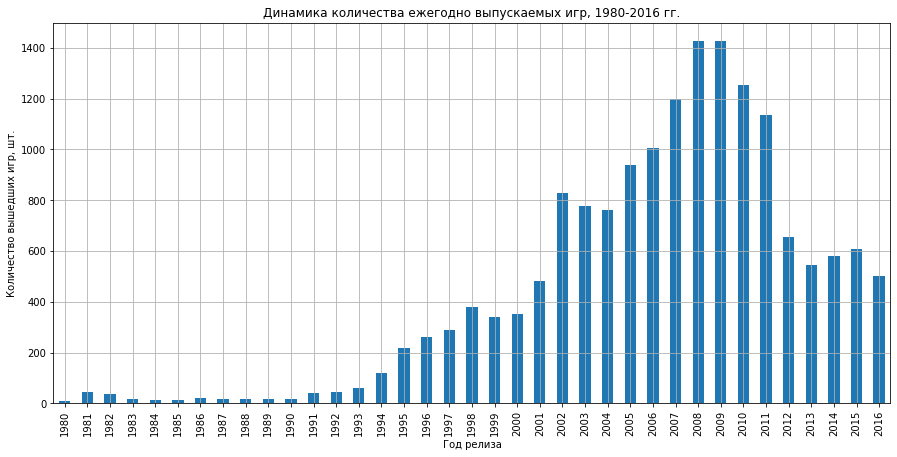

In [48]:
df.groupby('year_of_release')['name'].count().plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Динамика количества ежегодно выпускаемых игр, 1980-2016 гг.')
plt.xlabel('Год релиза')
plt.ylabel('Количество вышедших игр, шт.')
plt.show()

С 1980 по 1994 год количество выпускаемых игр было незначительным (не более 100 игр в год), с 1995 года наблюдается значительный рост количества ежегодно выпускаемых игр. Особенно выраженный рост происходит с 2002 года и к 2008-2009 гг достигает своих максимальных значений (около 1500 игр в год). После достигнутого пика количество выпускаемых игр начало снижаться с особенно выраженным падением в 2012 году. Учитывая незначительное количество ежегодно выпускаемых игр до 1998 год, можно заключить что этот период не будет иметь существенного значения при дальнейшем анализе. 

### Анализ продаж по платформам и выбор актуального периода ##

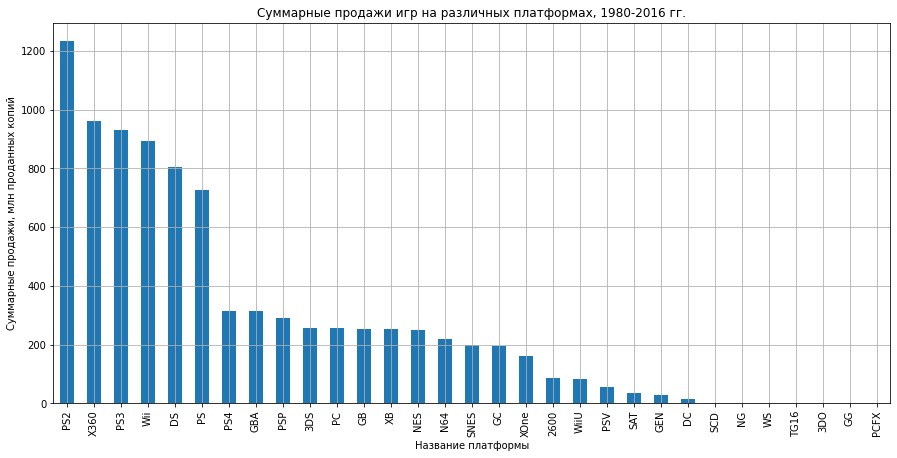

In [49]:
df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Суммарные продажи игр на различных платформах, 1980-2016 гг.')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи, млн проданных копий')
plt.show()

Можно выделить топ-6 платформ существенно лидирующих по суммарным продажам игр по сравнению с другими платформами. 

В порядке убывания по количеству проданных копий игр топ будет выглядеть следующим образом:

In [50]:
df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(6)

platform
PS2    1,233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
Name: total_sales, dtype: float64

Среди шести игровых платформ с наибольшим количеством проданных копий игр три (включая лидера) принадлежат компании SONY (PS2, PS3 и PS), две игровые платформы выпущены компанией NINTENDO (Wii, DS), и одна игровая платформа является продуктом компании MICROSOFT (X360).

Построим столбцовую диаграмму отражающую суммарные продажи игр для платформ из полученного топа по годам:

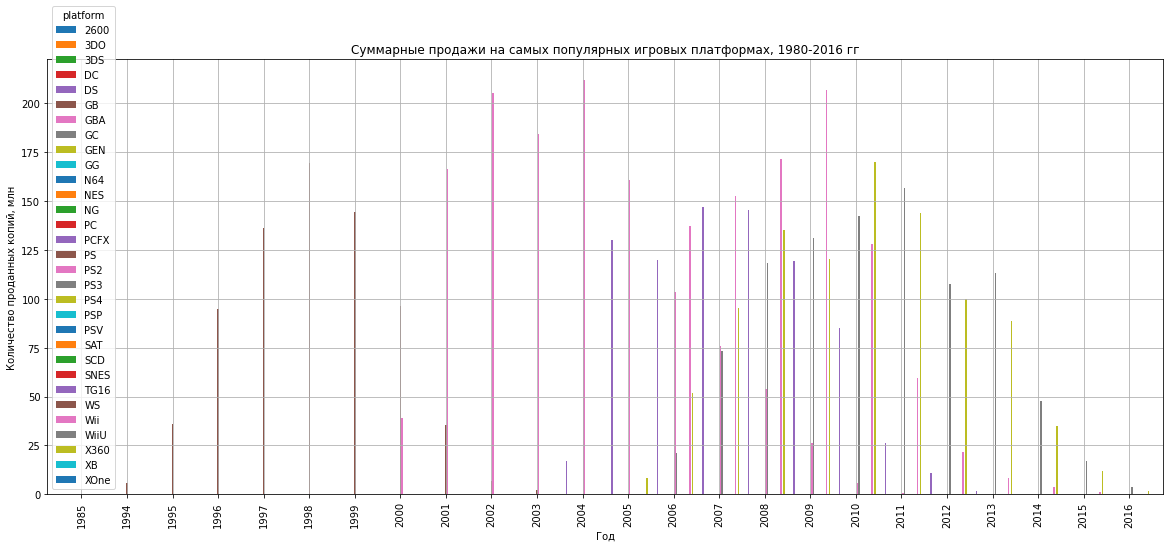

In [51]:
df.query('platform in ("PS2", "X360", "PS3", "Wii", "DS", "PS")').pivot_table(index='year_of_release', columns='platform',
               values='total_sales', aggfunc='sum').plot(kind='bar', width=1, grid=True, figsize=(20, 8))
plt.title('Суммарные продажи на самых популярных игровых платформах, 1980-2016 гг')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий, млн')
plt.show()

Период наиболее активных продаж в "жизни" представленных игровых платформ составляет от 5 до 7 лет, и как правило начинается на 2-3 год после релиза игровой платформы на рынке, последние 2-4 года существования платформы продажи выражено снижаются. Таким образом, описанный "жизненный цикл" игровой платформы занимает примерно 9-11 лет. Новые игровые платформы появляются когда ресурс маскимальных продаж предыдущего поколения исчерпан, т.е. примерно каждые 7-8 лет. Это можно хорошо проследить на примере игровых платформ от компании SONY, т.к. в данном случае имеет место последовательная смена игровых консолей разных поколений. Платформа следующего поколения появляется спустя 7 лет послезапуска предыдущей.

Исходя из преведенных выше данных, в качестве актуального периода для построения прогноза на 2017-й год следует использовать данные за предшествующие 5 лет.

In [52]:
df_analysis = df.query('year_of_release > 2011') #срез данных, который мы будем использовать для анализа

### Определение потенциально прибыльных платформ ##

Text(0, 0.5, 'Суммарные продажи, млн проданных копий')

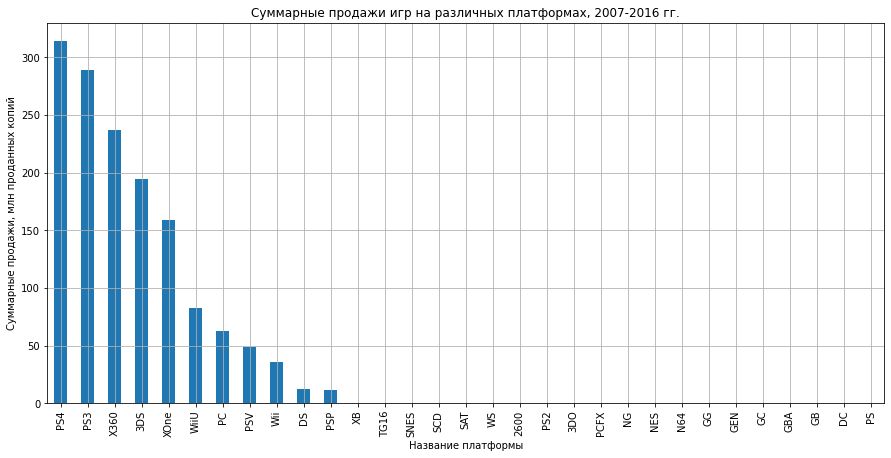

In [53]:
df_analysis.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(
    kind='bar', grid=True, figsize=(15, 7))
plt.title('Суммарные продажи игр на различных платформах, 2007-2016 гг.')
plt.xlabel('Название платформы')
plt.ylabel('Суммарные продажи, млн проданных копий')

За последние 5 лет анализируемого периода можно выделить пятёрку платформ отметившихся наибольшими продажами игр: PS4, PS3, Х360, 3DS и XOne.

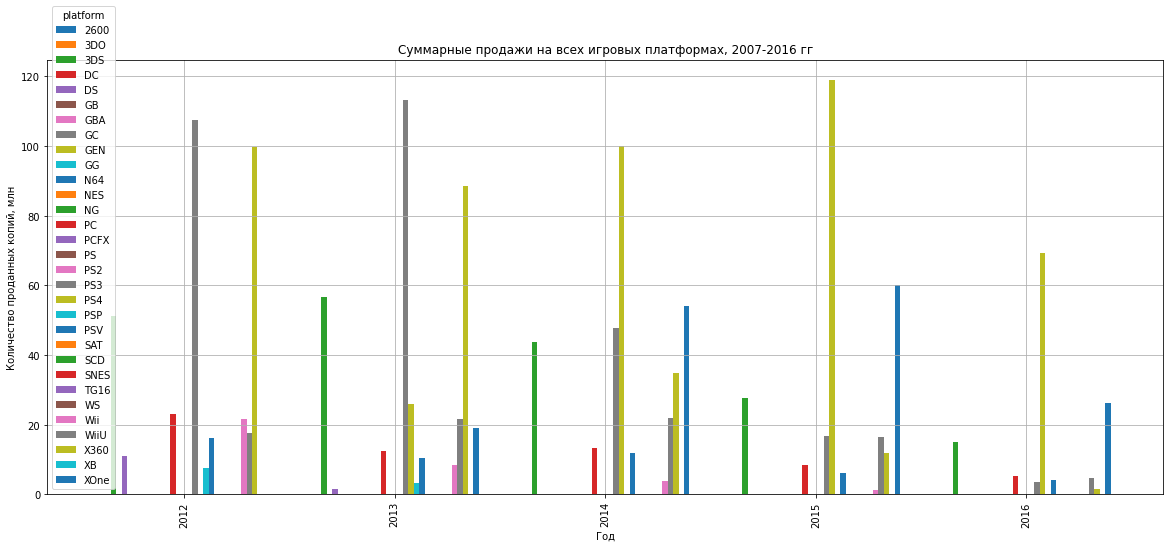

In [54]:
df_analysis.pivot_table(index='year_of_release', columns='platform',
               values='total_sales', aggfunc='sum').plot(kind='bar', width=0.8, grid=True, figsize=(20, 8))
plt.title('Суммарные продажи на всех игровых платформах, 2007-2016 гг')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий, млн')
plt.show()

При рассмотрении динамики продаж на разных платформах видно, что в целом продажи игр, довольно существенно снизились на всех платформах в 2016 году. В целом стоит ожидать, что самые современные платформы, такие как PS4 и XOne, в 2017 году покажут наиболее высокие продажи, как и в предыдущие годы.

### "Ящик с усами" по глобальным продажам в разбивке по платформам ##

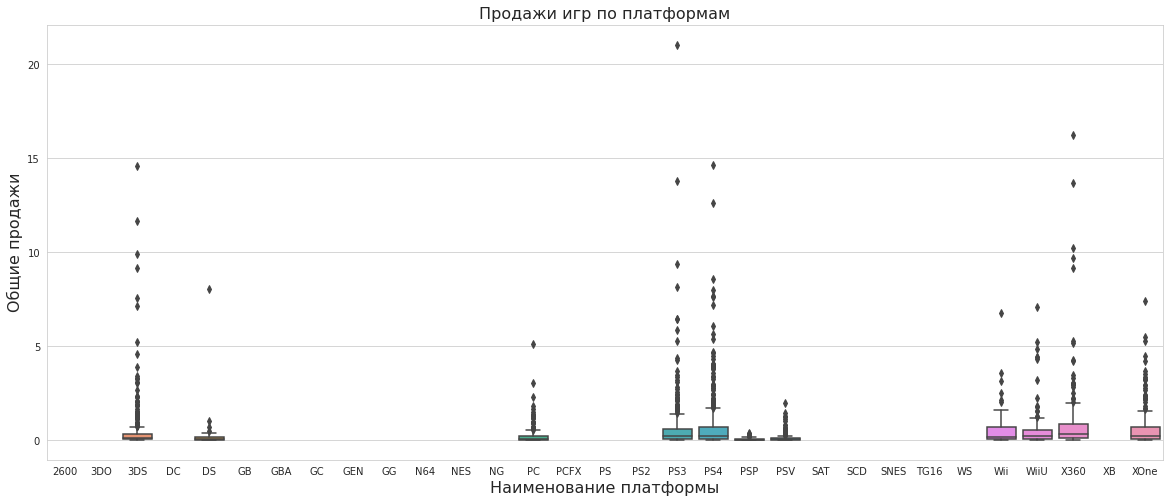

In [55]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 8))
boxplot = sns.boxplot(x=df_analysis['platform'], y=df_analysis['total_sales'])
boxplot.axes.set_title('Продажи игр по платформам', fontsize=16)
boxplot.set_xlabel('Наименование платформы', fontsize=16)
boxplot.set_ylabel('Общие продажи', fontsize=16)
plt.show()

In [56]:
df_analysis.query('total_sales > 20')

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05


Для четырех игровых платформ выходили игры которые продались тиражами более 10 млн копий: 3DS, PS3, PS4 и X360 (это платформы на которых в целом продажи были наибольшими). На PS3 выходила игра абсолютный рекордсмен продажи которой составили более 20 млн копий (это легендарная GTAV). Для того, чтобы пристальней рассмотреть "ящики", сделаем срез в котором игры продавались тиражами не более 2 млн.

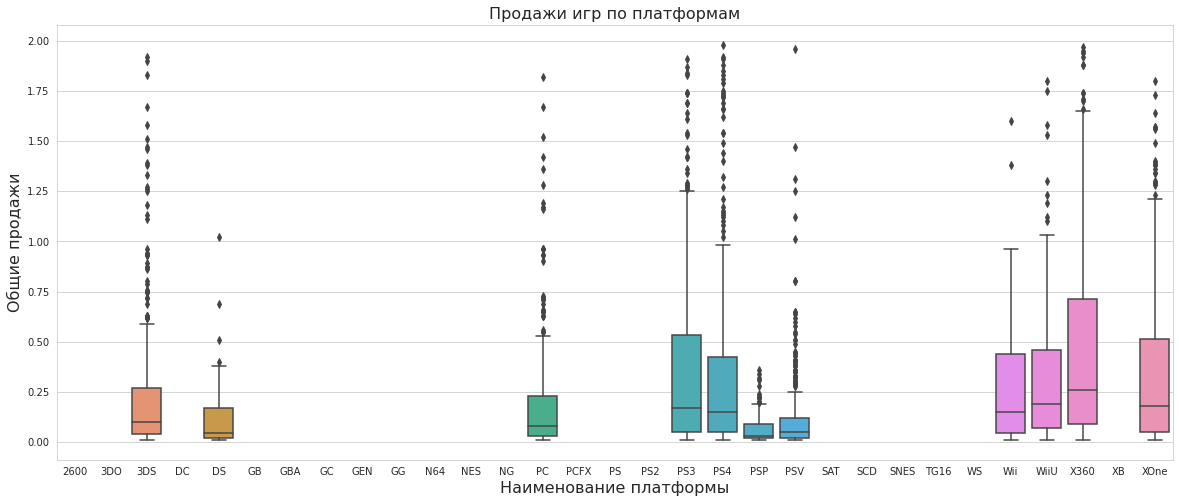

In [57]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 8))
boxplot = sns.boxplot(x=df_analysis.query('total_sales <= 2')['platform'], y=df_analysis.query('total_sales <= 2')['total_sales'])
boxplot.axes.set_title('Продажи игр по платформам', fontsize=16)
boxplot.set_xlabel('Наименование платформы', fontsize=16)
boxplot.set_ylabel('Общие продажи', fontsize=16)
plt.show()

Самые высокие медианы продаж наблюдаются на таких игровых платформах, как X360, XOne, Wii и WiiU, PS3 и PS4. Эти же платформы обладают самыми широкими межквартильными интервалами. Рекордсменом по обоим параметрам является игровая платформа X360. 

### Оценка влияния на продажи оценок пользователей и критиков ##

Оценим влияние оценок пользователей и критиков на продажи на примере наиболее популярной платформы PS4.

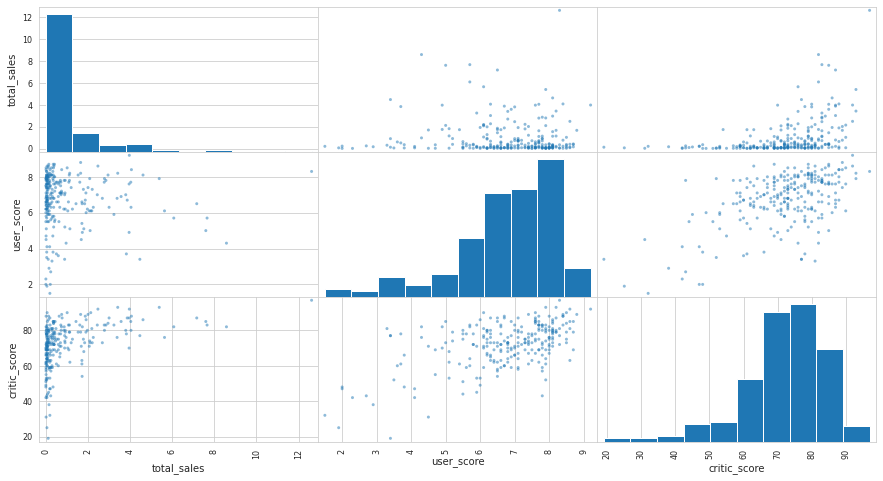

In [58]:
pd.plotting.scatter_matrix(df_analysis.query('platform == "PS4" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']], figsize=(15, 8))
plt.show()

Судя по скатерограммам, существенной зависимости между количеством проданных копий и оценками пользователей - нет, а вот между оценкой критиков и продажами может быть прямая связь. Рассчитаем коэффициенты корреляции между продажами и оценками, чтобы убедиться в этом.

In [59]:
df_analysis.query('platform == "PS4" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']].corr()['total_sales']

total_sales     1.00
user_score     -0.03
critic_score    0.41
Name: total_sales, dtype: float64

Исходя из полученных коэффициентов корреляции, можно заключить, что между оценками пользователей и продажами связи нет, а между оценками критиков и продажами наблюдается слабая прямая связь.

Теперь проведем аналогичную оценку по ещё четырем платформам с самыми значительными продажами и соотнесем с вышеназванными результатами.

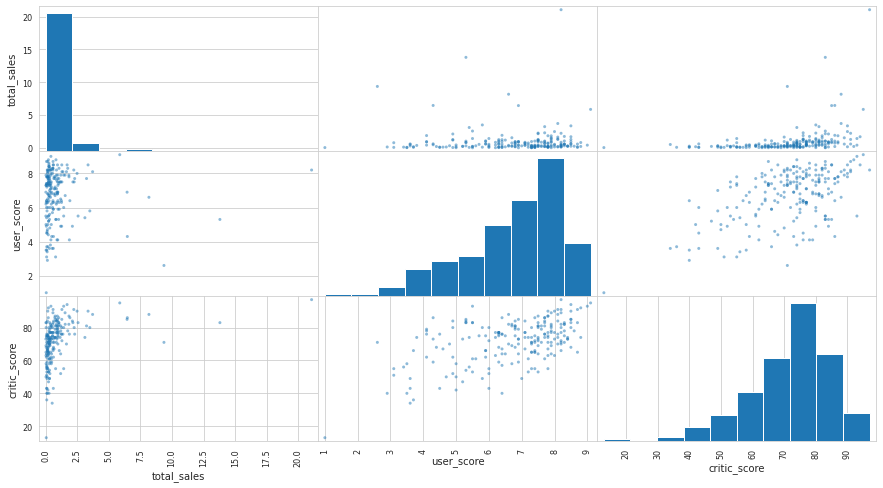

total_sales    1.00
user_score     0.00
critic_score   0.33
Name: total_sales, dtype: float64

In [60]:
pd.plotting.scatter_matrix(df_analysis.query('platform == "PS3" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']], figsize=(15, 8))
plt.show()
df_analysis.query('platform == "PS3" and user_score > -1 and critic_score > -1' )[['total_sales', 'user_score', 'critic_score']].corr()['total_sales']

Для PS3 ситуация схожая, отсутсвие связи между продажами и оценками игроков, и прямая слабая связь между продажами и оценками критиков.

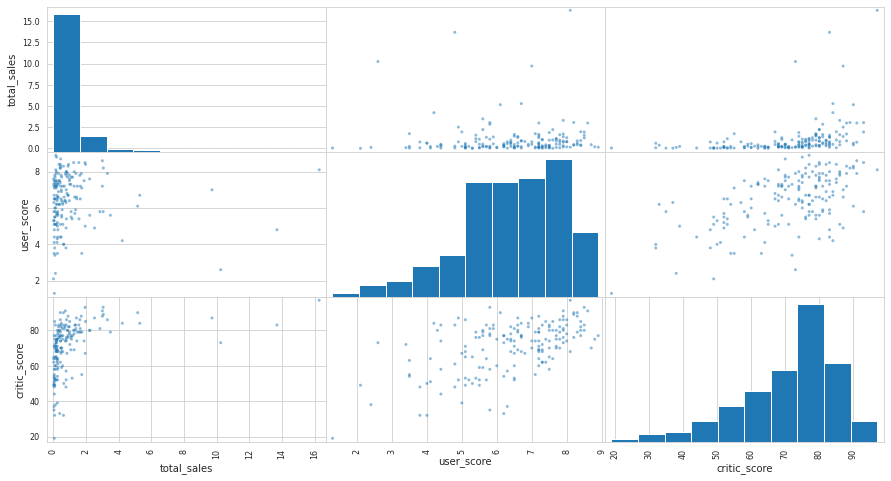

total_sales     1.00
user_score     -0.00
critic_score    0.36
Name: total_sales, dtype: float64

In [61]:
pd.plotting.scatter_matrix(df_analysis.query('platform == "X360" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']], figsize=(15, 8))
plt.show()
df_analysis.query('platform == "X360" and user_score > -1 and critic_score > -1' )[['total_sales', 'user_score', 'critic_score']].corr()['total_sales']

Тоже самое по Xbox 360.

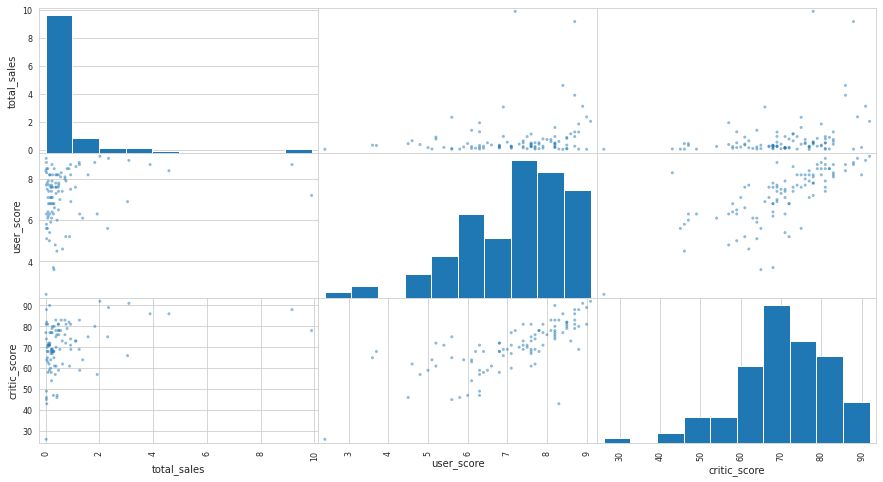

total_sales    1.00
user_score     0.20
critic_score   0.31
Name: total_sales, dtype: float64

In [62]:
pd.plotting.scatter_matrix(df_analysis.query('platform == "3DS" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']], figsize=(15, 8))
plt.show()
df_analysis.query('platform == "3DS" and user_score > -1 and critic_score > -1' )[['total_sales', 'user_score', 'critic_score']].corr()['total_sales']

На игровой платформе 3DS ситуация со связью продаж и оценок несколько отличается. Так между оценками пользователей и продажами наблюдается прямая слабая связь, как и между оценками критиков и продажами.

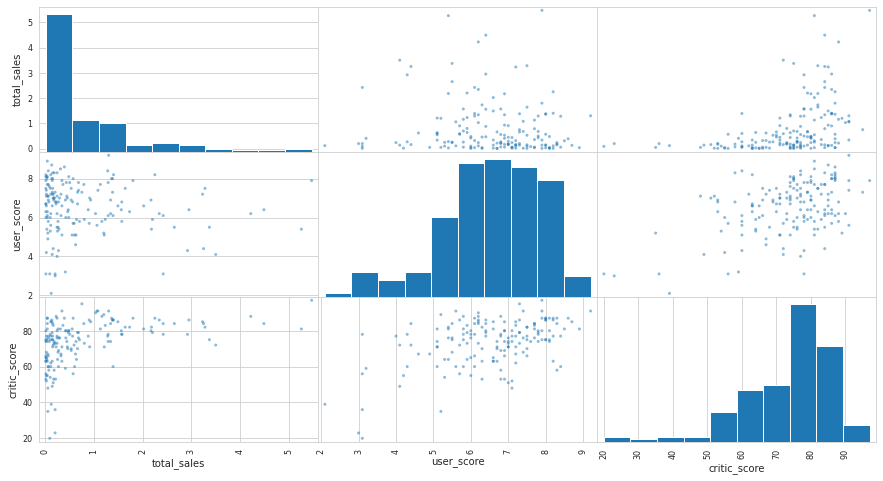

total_sales     1.00
user_score     -0.09
critic_score    0.41
Name: total_sales, dtype: float64

In [63]:
pd.plotting.scatter_matrix(df_analysis.query('platform == "XOne" and user_score > -1 and critic_score > -1')[['total_sales', 'user_score', 'critic_score']], figsize=(15, 8))
plt.show()
df_analysis.query('platform == "XOne" and user_score > -1 and critic_score > -1' )[['total_sales', 'user_score', 'critic_score']].corr()['total_sales']

Xbox One показала стабильный результат: оценки пользователей-продажи - отсутствие связи (или даже очень слабая обратная связь), оценки критиков-продажи - прямая слабая связь.

### Общее распределение игр по жанрам ##

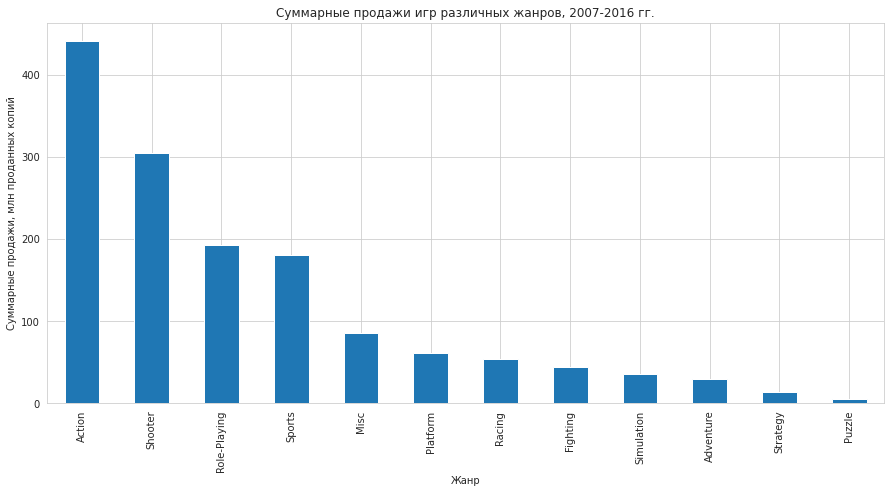

In [64]:
df_analysis.groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(
    kind='bar', grid=True, figsize=(15, 7))
plt.title('Суммарные продажи игр различных жанров, 2007-2016 гг.')
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи, млн проданных копий')
plt.show()

За анализируемый период по количеству проданных копий с серьёзным отрывом лидируют игры в жанре Action (около 450 млн копий), далее примерно с 300 млн проданных копий следуют игры жанра Shooter, далее следуют игры жанров RPG и Sports (190 и 180 млн проданных копий). Продажи игр остальных жанров существенно ниже и не достигают 100 млн проданных копий.

Выше приведены абсолютные цифры продаж, но чтобы выявить самый прибыльный жанр правильней сравнить относительные показатели, ведь возможно, игр определенного жанра просто выходило значительно больше, а при этом на одну вышедшую игру данного жанра проданных копий может быть не так много.

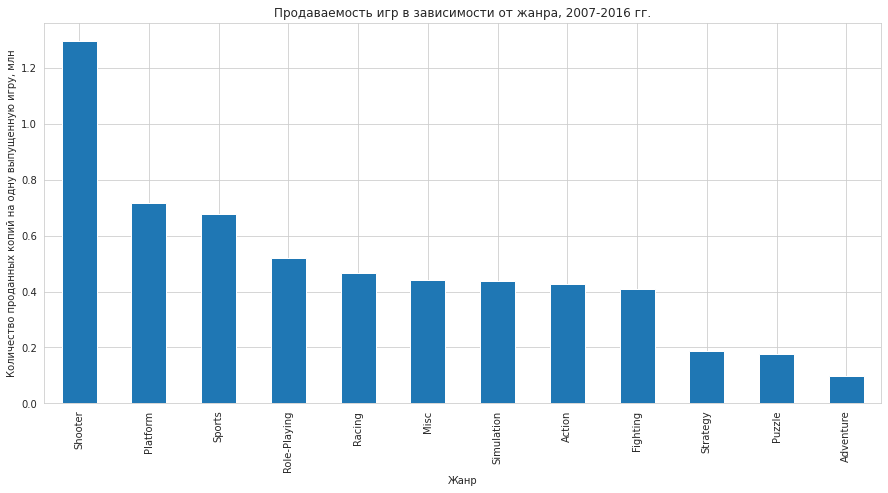

In [65]:
df_analysis.groupby('genre')['total_sales'].mean().sort_values(ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Продаваемость игр в зависимости от жанра, 2007-2016 гг.')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий на одну выпущенную игру, млн')
plt.show()

Самым продаваемым жанром оказался жанр шутер с огромным отрывом. Второй результат показывает платформеры, несмотря на то что их общие продажи весьма скромные. Sports и RPG занимают 3 и 4 позиции, далее с несильно различающимися показателями следуют жанры Racing, Misc, Simulation, Action и Fighting. Самыми плохо продаваемыми являются игры жанра Strategy, Puzzle и Adventure.

### Выводы ##

**В ходе исследовательского анализа данных, выявлено следующее:**

- меньше всего игр выпускалось в 1980-1994 гг.;
- с 1995 года количество игр росло, и достигло максимума к 2008-2009 гг, после чего количество ежегодно выпускаемых игр стало уменьшаться;
- за 1980-2016 гг наибольшими суммарными продажами игр отметились шесть платформ (в порядке убывания): PS2, X360, PS3, Wii, DS, PS;
- средний "срок жизни" игровой платформы составляет 9-11 лет, наиболее активные продажи игр наблюдаются в течение 5-7 лет;
- наиболее перспективными в плане продаж игр на 2017-й год, исходя из продаж за последние 5 лет, следует считать такие игровые платформы, как PS4 и XOne;
- самой популярной игровой платформой за 2012-2016 гг стала PS4;
- абсолютный рекорд по продажам за 2012-2016 гг установила GTAV на платформе PS3;
- при анализе по игровой платформе PS4 выявлено отсутствие связи между оценками пользователей и продажами (r=-0,03) и слабая прямая связь между оценками критиков и продажами (r=0,41);
- при анализе другим популярным платформам - результат аналогичный PS4, за исключением платформы 3DS показавшей прямую слабую связь, как между оценками критиков и продажами, так и между оценками пользователей и продажами;
- за 2012-2016 гг наибольшими продажами отметились игры жанров (в порядке убывания): Action, Shooter, RPG, Sports.
- за 2012-2016 гг топ-5 игровых жанров по количеству проданных копий игр на одну вышедшую игру на каждой платформе (в порядке убывания): Shooter, Platform, Sports, RPG, Racing.

## Составление портрета пользователя каждого региона #

### Топ-5 популярных платформ по разным регионам ##

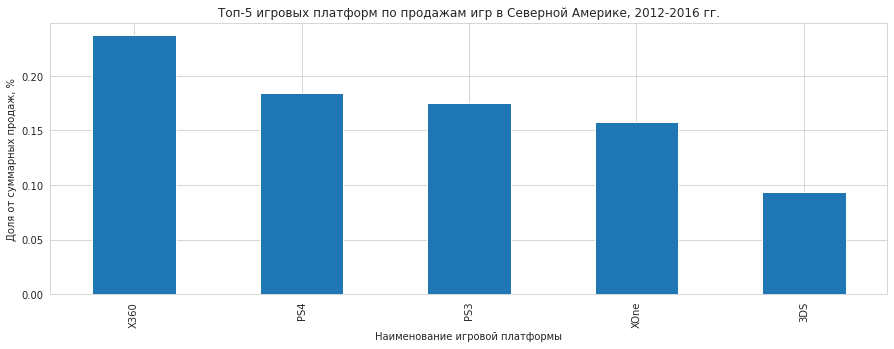

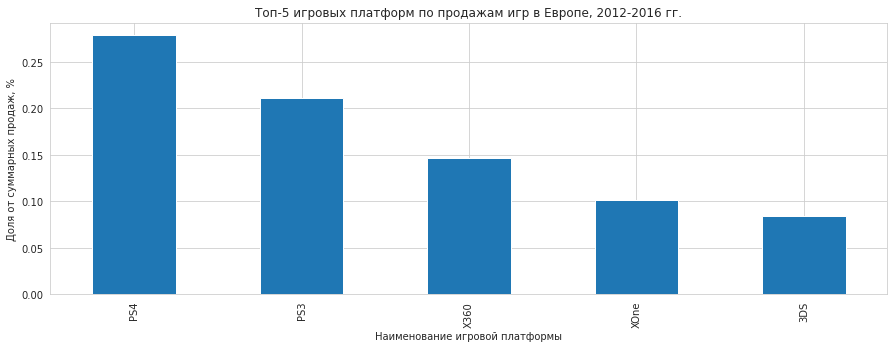

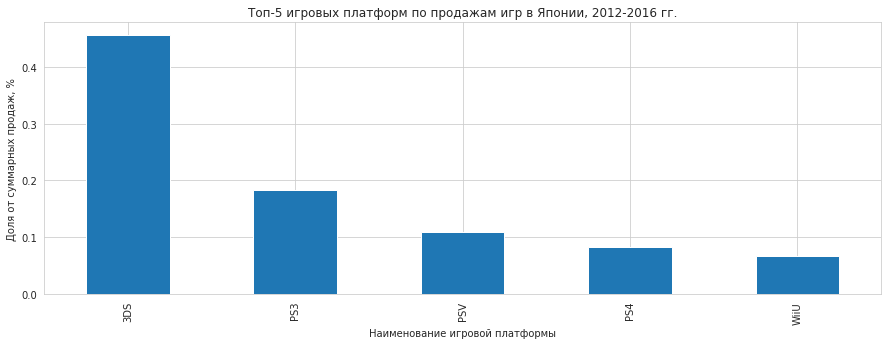

In [66]:
(df_analysis.groupby('platform')['na_sales'].sum() / df_analysis['na_sales'].sum()).sort_values(ascending=False).head().plot(
    kind='bar', grid=True, figsize=(15, 5))
plt.title('Топ-5 игровых платформ по продажам игр в Северной Америке, 2012-2016 гг.')
plt.xlabel('Наименование игровой платформы')
plt.ylabel('Доля от суммарных продаж, %')
plt.show()

(df_analysis.groupby('platform')['eu_sales'].sum() / df_analysis['eu_sales'].sum()).sort_values(ascending=False).head().plot(
    kind='bar', grid=True, figsize=(15, 5))
plt.title('Топ-5 игровых платформ по продажам игр в Европе, 2012-2016 гг.')
plt.xlabel('Наименование игровой платформы')
plt.ylabel('Доля от суммарных продаж, %')
plt.show()

(df_analysis.groupby('platform')['jp_sales'].sum() / df_analysis['jp_sales'].sum()).sort_values(ascending=False).head().plot(
    kind='bar', grid=True, figsize=(15, 5))
plt.title('Топ-5 игровых платформ по продажам игр в Японии, 2012-2016 гг.')
plt.xlabel('Наименование игровой платформы')
plt.ylabel('Доля от суммарных продаж, %')
plt.show()

В США лидером игрового рынка является игровая консоль от американской компании Microsoft - X360, на игры для которой приходится более 25% всех проданных копий. Второе и третье место с небольшой разницей занимают консоли PS4 и PS3 от Sony. Далее, с чуть более чем 15% долей, следует еще одна консоль от Microsoft - XOne. Замыкает пятерку портативная консоль от Nintendo - 3DS.

В Европе топ-5 игровых платформ занимающих наибольшие доли рынка видео-игр, представлен теми же самыми консолями, что и в США, однако доли их распределены совершенно иначе. Более 1/4 всех проданных игр - это игры для PS4, на втором месте более старая версия консоли от Sony (около 20%). Третью и четвертую позицию занимает пара консолей от Microsoft - X360 и XOne, с долями около 15% и 10% соответственно. На пятом месте, также как и в Северной Америке, находится портативная консоль 3DS.   

Японский рынок видео-игр кардинально отличается от описанных выше. Во-первых в топ-5 платформ по Японии отсутствуют консоли от Microsoft. Абсолютным лидером является портативная консоль 3DS, занимающая почти половину рынка. Далее следуют три игровые платформы от Sony: PS3, PSV и PS4. Замыкает пятерку лидеров игрового японского рынка ещё одна портативная консоль от Nintendo - WiiU. Обращает на себя внимание тот факт, что в Японии чрезвычайно развит портативный гейминг, суммарная доля проданных игр для портативных консолей составляет более 60%. 

### Топ-5 популярных игровых жанров по разным регионам ##

In [67]:
top_na = (df_analysis.groupby('genre')['na_sales'].sum().sort_values(
    ascending=False).head().reset_index()['genre']).to_list()
top_eu = (df_analysis.groupby('genre')['eu_sales'].sum().sort_values(
    ascending=False).head().reset_index()['genre']).to_list()
top_jp = (df_analysis.groupby('genre')['jp_sales'].sum().sort_values(
    ascending=False).head().reset_index()['genre']).to_list()

In [68]:
df_genres_na = df_analysis[['genre', 'na_sales']]
df_genres_na['genre'] = df_genres_na['genre'].where(df_genres_na['genre'].isin(top_na), 'Other genres')
df_genres_eu = df_analysis[['genre', 'eu_sales']]
df_genres_eu['genre'] = df_genres_eu['genre'].where(df_genres_eu['genre'].isin(top_eu), 'Other genres')
df_genres_jp = df_analysis[['genre', 'jp_sales']]
df_genres_jp['genre'] = df_genres_jp['genre'].where(df_genres_jp['genre'].isin(top_jp), 'Other genres')

/tmp/ipykernel_609/3981794482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres_na['genre'] = df_genres_na['genre'].where(df_genres_na['genre'].isin(top_na), 'Other genres')
/tmp/ipykernel_609/3981794482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres_eu['genre'] = df_genres_eu['genre'].where(df_genres_eu['genre'].isin(top_eu), 'Other genres')
/tmp/ipykernel_609/3981794482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [69]:
na = (df_genres_na.groupby('genre')['na_sales'].sum() / df_genres_na['na_sales'].sum()).sort_values(ascending=False)
eu = (df_genres_eu.groupby('genre')['eu_sales'].sum() / df_genres_eu['eu_sales'].sum()).sort_values(ascending=False)
jp = (df_genres_jp.groupby('genre')['jp_sales'].sum() / df_genres_jp['jp_sales'].sum()).sort_values(ascending=False)

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)
/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


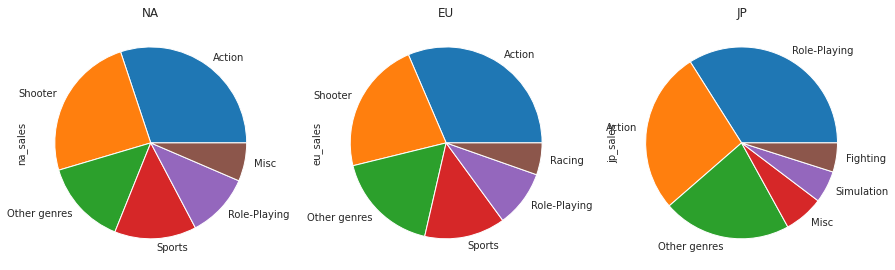

In [70]:
plt.figure(figsize=(15, 15))
plt.title('NA')
plt.subplot(3, 3, 1)
na.plot(kind='pie')
plt.title('NA')
plt.subplot(3, 3, 2)
eu.plot(kind='pie')
plt.title('EU')
plt.subplot(3, 3, 3)
jp.plot(kind='pie')
plt.title('JP')
plt.show()

В Свеверной Америке и Европе наблюдаются схожие жанровые предпочтения среди игроков. Наиболее популярные жанры это Action и Shooter, третьими по популярности являются игры жанра Sports, четвертыми RPG. Различается только жанр замыкающий топ-5 - в Северной Америке это игры жанр которых определен как Разное, а в Европе это игры жанра Racing.

Иная ситуация наблюдается в Японии. Наиболее популярным жанром среди японских игроков является RPG, второй по популярности жанр, как и в Северной Америке с Европой, это Action. Далее следуют игры жанр которых определен как Misc, четвертое место занимают игры в жанре Simulation, и замыкают топ-5 файтинги.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Для оценки влияния рейтинга ESRB на продажи игр в отдельном регионе рассчитаем продаваемость игр различных жанров, как отношение количества проданных игр конкретного жанра к общему количеству выпущенных игр этого жанра на каждой платформе, в зависимости от региона.

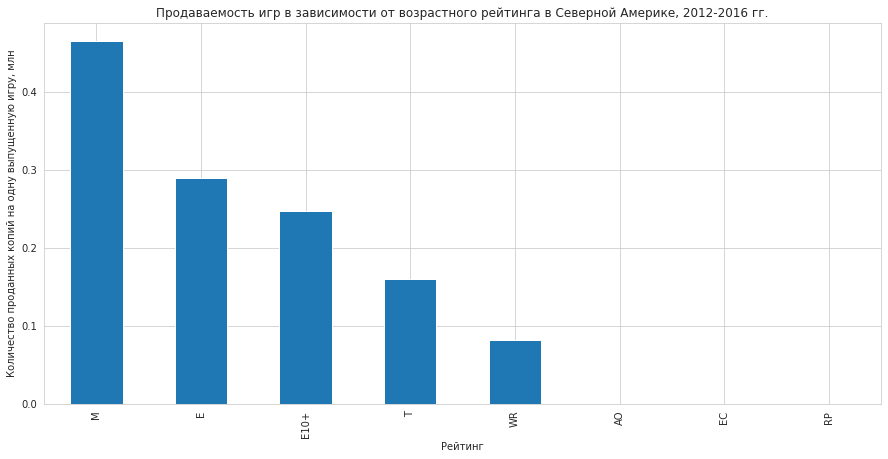

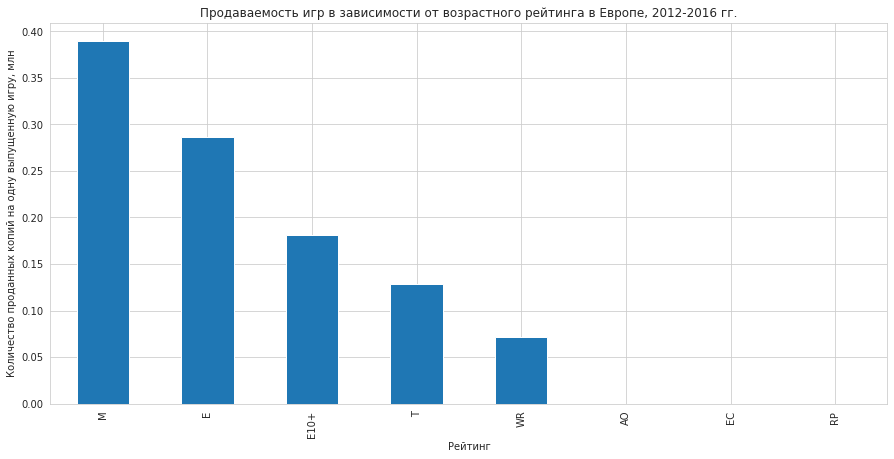

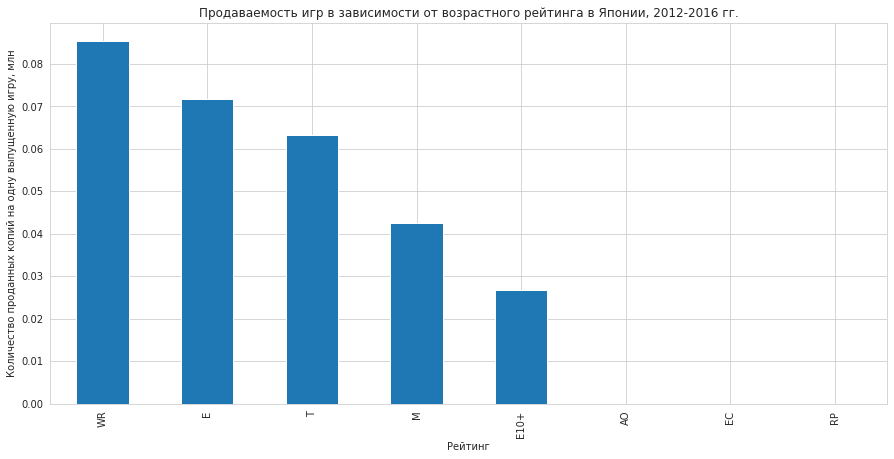

In [71]:
(df_analysis.groupby('rating')['na_sales'].sum() / df_analysis.groupby('rating')['na_sales'].count()).sort_values(
    ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Продаваемость игр в зависимости от возрастного рейтинга в Северной Америке, 2012-2016 гг.')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных копий на одну выпущенную игру, млн')
plt.show()

(df_analysis.groupby('rating')['eu_sales'].sum() / df_analysis.groupby('rating')['eu_sales'].count()).sort_values(
    ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Продаваемость игр в зависимости от возрастного рейтинга в Европе, 2012-2016 гг.')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных копий на одну выпущенную игру, млн')
plt.show()

(df_analysis.groupby('rating')['jp_sales'].sum() / df_analysis.groupby('rating')['jp_sales'].count()).sort_values(
    ascending=False).plot(kind='bar', grid=True, figsize=(15, 7))
plt.title('Продаваемость игр в зависимости от возрастного рейтинга в Японии, 2012-2016 гг.')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных копий на одну выпущенную игру, млн')
plt.show()

Ситуация в Северной Америке и Европе по продаваемости игр в зависимости от рейтинга ESRB является идентичной. Лучше всего продаются игры с возрастным рейтингом М(17+), вторыми по продаваемости являются игры с рейтингом E(6+), далее следуют игры, имеющие рейтинг E10+, и T(13+). Наихудщими продажами и в Старом и в Новом Свете отметились игры не имеющие возрастного рейтинга ESRB (ну или по крайней мере нам их рейтинг не известен).

По всему видно, что японскую геймерскую публику рейтинг ESRB совершенно не беспокоит, поскольку лучше всего продаются игры вообще его не имеющие. Среди тех игр, которые имеют возрастной рейтинг ESRB, наиболее продаваемыми являются игры с рейтингом E, далее с небольшим разрывом следуют игры "Для подростков". Количество проданных копий на одну выпущенную игру у наиболее продаваемых в Северной Америке и Европе игр с рейтингом М, в два раза ниже чем у игр без возрастного рейтинга. Самая низкая продаваемость в Японии у игр с возрастным рейтингом Е10+.

Таким образом, можно заключить, что рейтинг ESRB может влиять на продажи в Северной Америке и Европе. При прочих равных, если мы хотим добиться максимальных продаж, то в Северной Америке и Европе стоит выпускать игру "Для взрослых". В Японии рейтинг ESRB такого влияния на продажи не имеет, и лучше всего продаются игры вообще без него.

### Вывод

Портреты пользователя из Северной Америки и Европы во многом сходны, так например, список топ-5 предпочитаемых платформ полностью совпадает, но есть и свои особенности, так в Северо-Американском регионе преобладают продажи игр для консоли X360, в то время, как в Европе самой популярной консолью является PS4. Топ-5 игровых жанров в Северной Америке и Европе, также идентичны, за тем лишь исключением, что в Северной Америке топ замыкается играми c жанром Misc, а в Европе гоночными симуляторами. И в Северной Америке, и в Европе лучше всего продаются игры с возрастным рейтингом M. 

Портрет японского пользователя существенно отличается от северо-американского и европейского по всем проанализированным параметрам. На японском игровом рынке доминируют портативные консоли (в первую очередь от компании Nintendo), самым популярным игровым жанром является RPG, а рейтинг ESRB не оказывает существенного влияния на продажи.

Такие различия вполне ожидаемы, т.к. несмотря на наличие различий, в культурно-социальном плане Северо-Американский и Европейский регион гораздо ближе друг к другу, чем к Японии.

## Проверка гипотез

### Средние пользовательские рейтинги платформ *Xbox One*  и *PC*  одинаковые?

Для ответа на поставленный вопрос, выдвинем и проверим нулевую и альтернативную гипотезы. Нулевая гипотеза должна содержать в себе равенство, поэтому сформулируем её так: "Средние пользовательские рейтинги платформ *Xbox One* и *PC* одинаковые". Тогда альтернативная гипотеза будет звучать следующим образом: "Средние пользовательские рейтинги платформ *Xbox One* и *PC* различаются". Для проверки гипотез используем t-тест для не связанных совокупностей, т.к. они независимы друг от друга. Для начала оценим размеры выборок:

In [72]:
print('Количество игр для Xbox One:', df_analysis.query('platform == "XOne"')['user_score'].count())
print('Количество игр для PC:', df_analysis.query('platform == "PC"')['user_score'].count())

Количество игр для Xbox One: 247
Количество игр для PC: 250


In [73]:
df_analysis.query('platform == "XOne"')['user_score'].min()

-1.0

Размеры выборок существенно различаются, поэтому установим параметр equal_var=False при вызове метода для проведения t-теста. Для проверки гипотезы испроьзуем общепринятый критический уровень статистической значимости 0.05.

In [74]:
alpha = .05 #критический уровень статистической значимости
result = st.ttest_ind(df_analysis.query('platform == "XOne"')['user_score'].to_list(),
                      df_analysis.query('platform == "PC"')['user_score'].to_list(), equal_var=False)
print('Средний пользовательский рейтинг игр для платформы Xbox One:', df_analysis.query('platform == "XOne"')['user_score'].mean().round(2))
print('Средний пользовательский рейтинг игр для платформы PC:', df_analysis.query('platform == "PC"')['user_score'].mean().round(2))
print('p-значение', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг игр для платформы Xbox One: 4.54
Средний пользовательский рейтинг игр для платформы PC: 5.12
p-значение 0.05619765758385681
Нельзя отвергнуть нулевую гипотезу


По результатам проверки выдвинутых гипотез, можно заключить что средние пользовательские рейтинги игр для платформы *Xbox One* и *PC* не одинаковые. В исследованных выборках средние пользовательские рейтинги игр для *Xbox One* и *PC* различаются несильно, рейтинг игр для *PC* выше всего на 0,19.

### Средние пользовательские рейтинги игр жанра *Action*  и *Sports*  разные?

Для ответа на данный вопрос воспользуемся вышеиспользованным алгоритмом. Нулевая гипотеза будет звучать следующим образом: "Средние пользовательскте рейтинги игр жанра *Action* и *Sports* не различаются", согласно альтернативной гипотезе: "Средние пользовательскте рейтинги игр жанра *Action* и *Sports* различаются". Оценим размер выборок:

In [75]:
print('Количество игр жанра Action:', df_analysis.query('genre == "Action"')['user_score'].count())
print('Количество игр жанра Sports:', df_analysis.query('genre == "Sports"')['user_score'].count())

Количество игр жанра Action: 1031
Количество игр жанра Sports: 268


Игр жанра Action в два раза больше, поэтому установим параметр equal_var=False при вызове метода для проведения t-теста, примем критический уровень статистической значимости 0.05.

In [76]:
alpha = .05 #критический уровень статистической значимости
result = st.ttest_ind(df_analysis.query('genre == "Action"')['user_score'].to_list(),
                      df_analysis.query('genre == "Sports"')['user_score'].to_list(), equal_var=False)
print('Средний пользовательский рейтинг игр жанра Action:', df_analysis.query('genre == "Action"')['user_score'].mean().round(2))
print('Средний пользовательский рейтинг игр жанра Sports:', df_analysis.query('genre == "Sports"')['user_score'].mean().round(2))
print('p-значение', result.pvalue)
if result.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг игр жанра Action: 2.97
Средний пользовательский рейтинг игр жанра Sports: 3.7
p-значение 0.0020018209559324713
Нулевая гипотеза отвергнута


Нулевая гипотеза отвергнута, а значить рейтинг игр жанров *Action* и *Sports* различаются. В представленных выборках средняя оценка игр жанра *Sports* ниже на 0,45.

### Вывод

В результате проведенной проверки гипотез, выявлено следующее:
- средние пользователи оценки игр для *Xbox One* и *PC*, и игр жанра *Action* и *Sports* различаются;
- в представленных выборках средняя пользовательская оценка игр для *PC* выше, чем оценка игр для *Xbox One* на 0,19 балла; средняя пользовательская оценка игр жанра *Action* выше, чем оценка игр жанра *Sports* на 0,45.

## Общий вывод

Исходя из полученных в ходе анализа данных, можно сделать следующее заключение о потенциально популярных играх в 2017-ом году в рекламные компании которых нужно вкладывать средства в первую очередь:
1. Наиболее перспективной с точки зрения продаж игр в 2017-ом году следует считать игровые платформы PS4 и Xbox One, т.к. эти консоли появились сравнительно недавно и в ближайшие 3-5 лет будут находятся в фазе наиболее активных продаж.
2. Как показал анализ наиболее перспективными жанрами, в плане количества продаваемых копий игры, являются жанры Action, Shooter и Sports. 
3. Стоит учесть и возрастной рейтинг выходящих игр: самыми продаваемыми являются игры с возрастным рейтингом M (Для взрослых, 17+).
4. Всё вышесказанное справедливо для самых значимых по продажам Северо-Американского и Европейского регионов, если учитывать региональные особенности Японского рынка, то учитывая преобладание портативного гейминга,  ставку стоит сделать на игры для таких консолей 3DS и WiiU, хотя период наиболее активных продаж для них уже на исходе. Также потенциально перспективной следует считать портативную консоль нового поколения от Nintendo (Nintendo Switch, предствленная в 2016 году), релиз которой запланирован на 2017-й год. Из стационарных игровых платформ, наиболее перспективной для Японского рынка следует считать PS4. Также из региональных особенностей японского рынка стоит отметить, большую популярность RPG-игр и отсутствия выраженного влияния рейтинга ESRB на продаваемость, если же продаваемая игра все-таки имеет рейтинг ESRB, то наилучшими продажами отмечаются игры с рейтингом E.